# Deep learning Keras-based solution of the MNIST problem

## 1. Load data

In [1]:
# Todo stop the numbers to vary from time to time
# Todo add a pipeline to scale params
# Todo choose the best params and cnn architecture
# Todo implement augmentation
# Todo try to get a pretrained cnn
# Todo early stop for the best model
# Todo print the numbers in square like in the book

In [2]:
_seed = 1337

In [3]:
# Reproducibility
import os
os.environ['PYTHONHASHSEED'] = '0'

import numpy as np
import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(_seed)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(_seed)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(_seed)


In [4]:
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
log = logging.getLogger()

In [5]:
import numpy as np
import pandas as pd
from pathlib import Path

import argparse
args = argparse.Namespace()
args.raw_train = pd.read_csv('../data/train.csv.zip')
args.raw_test = pd.read_csv('../data/test.csv.zip')
args.predictions_folder = Path('../predictions')

args.n_splits = 5
args.n_jobs = -1
args.val_fraction = 0.1
args.epochs = 3
args.model_name = 'deep-learning-keras-model.hdf5'
args.seed=_seed

args.train = args.raw_train.iloc[:, 1:].copy()
args.labels = args.raw_train['label'].copy()
args.test = args.raw_test.copy()

args.run_baseline = False
args.run_early_stop = True
args.run_grid_search = False
args.run_kfold_validation = False

args.predictions_folder.mkdir(parents=True, exist_ok=True) 

In [6]:
args.raw_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
args.raw_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
args.raw_train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [34]:
def plot_number(pixels_2d, label=None, size_inches=None):
    fig, ax = plt.subplots()
    if label is not None:
        ax.set_title(label)
    if size_inches:
        fig.set_size_inches(size_inches[0], size_inches[1])
    imgplot = ax.imshow(pixels_2d)

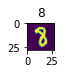

In [35]:
# Matlbab state-based style of image rendering 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

random_row = random.randrange(0, args.raw_train.shape[0], 1)
label = args.raw_train.iloc[random_row, 0]
pixels_2d = args.raw_train.iloc[random_row, 1:].to_numpy().reshape(28, 28)
plot_number(pixels_2d, label, (0.5, 0.5))

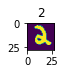

In [36]:
# OO-style image rendering
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

random_row = random.randrange(0, args.raw_train.shape[0], 1)
label = args.raw_train.iloc[random_row, 0]
pixels_2d = args.raw_train.iloc[random_row, 1:].to_numpy().reshape(28, 28)
plot_number(pixels_2d, label, (0.5, 0.5))

## 2. Training of basic models

In [12]:
import sklearn.utils.multiclass

X = args.train.to_numpy().reshape(args.train.shape[0], 28, 28, 1)
y = pd.get_dummies(args.labels, prefix='label').to_numpy()
y_sparse = args.labels.to_numpy()
x = args.test.to_numpy().reshape(args.test.shape[0], 28, 28, 1)

log.info('X.shape: %s', repr(X.shape))
log.info('X[0][14][14]: %s', X[0][14][14])

log.info('y.shape: %s', repr(y.shape))
log.info('y[0], %s', y[0])
log.info('type of target y: %s', repr(sklearn.utils.multiclass.type_of_target(y)))

log.info('y_sparse.shape: %s', repr(y_sparse.shape))
log.info('y_sparse: %s', repr(y_sparse))
log.info('y_sparse[0]: %s', y_sparse[0])
log.info('type of target y_sparse: %s', repr(sklearn.utils.multiclass.type_of_target(y_sparse)))

2020-08-17 18:40:38,817 : INFO : X.shape: (42000, 28, 28, 1)
2020-08-17 18:40:38,818 : INFO : X[0][14][14]: [254]
2020-08-17 18:40:38,819 : INFO : y.shape: (42000, 10)
2020-08-17 18:40:38,820 : INFO : y[0], [0 1 0 0 0 0 0 0 0 0]
2020-08-17 18:40:38,825 : INFO : type of target y: 'multilabel-indicator'
2020-08-17 18:40:38,826 : INFO : y_sparse.shape: (42000,)
2020-08-17 18:40:38,826 : INFO : y_sparse: array([1, 0, 1, ..., 7, 6, 9])
2020-08-17 18:40:38,827 : INFO : y_sparse[0]: 1
2020-08-17 18:40:38,829 : INFO : type of target y_sparse: 'multiclass'


In [13]:
def csv_sparse_predictions(predictions_sparse, filename):
    image_ids = np.arange(1, len(predictions_sparse) + 1)
    submission = pd.DataFrame({'ImageId': image_ids, 'Label': predictions_sparse})
    filepath = args.predictions_folder/filename
    
    submission.to_csv(filepath, index=False)
    log.info('Saved file: %s', filepath)
    
def csv_predictions(predictions, filename):
    log.debug('predictions.shape: %s', repr(predictions.shape))
    predictions_sparse = np.argmax(predictions, axis=1)
    csv_sparse_predictions(predictions_sparse, filename)

In [14]:
def plot_history(history):
    log.info("History keys: %s", history.history.keys())
    # Accuracy
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(history.history['accuracy'], label='Train')
    ax.plot(history.history['val_accuracy'], label='Test')
    ax.set_title('Model accuracy')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.grid(True)
    ax.legend(['Train', 'Val'], loc='lower right')
    
    # Loss
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.grid()
    plt.show()

In [15]:
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier

def cross_val_score_sklearn(sklearn_model, X, y, scoring='accuracy', n_splits=args.n_splits, fit_params=None):
    cvs = cross_val_score(sklearn_model, X, y, cv=n_splits, n_jobs=args.n_jobs, fit_params=fit_params)
    log.info('CV mean accuracy: %0.5f. std: %0.5f', cvs.mean(), cvs.std())
    return cvs
    
def cross_val_score_keras(keras_model_builder, X, y, scoring='accuracy', n_splits=args.n_splits, fit_params={'epochs': args.epochs}):
    keras_classifier = KerasClassifier(keras_model_builder)
    return cross_val_score_sklearn(keras_classifier, X, y, scoring=scoring, n_splits=n_splits, fit_params=fit_params)

In [16]:
from keras import models

def build_model(layers_list, optimizer='rmsprop',
                loss='sparse_categorical_crossentropy', metrics_tuple=('accuracy')):
    model = models.Sequential(layers_list)
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=[metrics_tuple])
    log.info(model.summary())
    return model

In [17]:
basic_predictions = None

### 2.1 Baseline

In [18]:
from keras import layers 

def build_baseline_model_sparse():
    layers_list = [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ]
    return build_model(layers_list=layers_list)

In [19]:
%%time

def baseline():
    model = build_baseline_model_sparse()
    history = model.fit(X, y_sparse, validation_split=args.val_fraction, epochs=args.epochs, batch_size=64, verbose=1)
    plot_history(history)
    predictions = model.predict(x)
    csv_predictions(predictions, 'cnn_baseline_predictions.csv')
    if args.run_kfold_validation:
        cross_val_score_keras(build_baseline_model_sparse, X, y_sparse)
    return predictions
    
if args.run_baseline:
    baseline()

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs


### 2.2 Early stop and reduction of learning rate

2020-08-17 18:40:39,074 : INFO : None


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

2020-08-17 18:41:07,776 : INFO : History keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


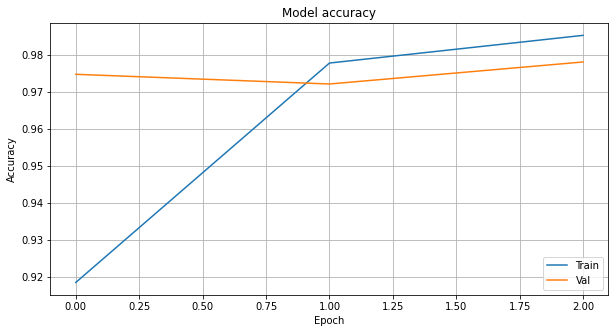

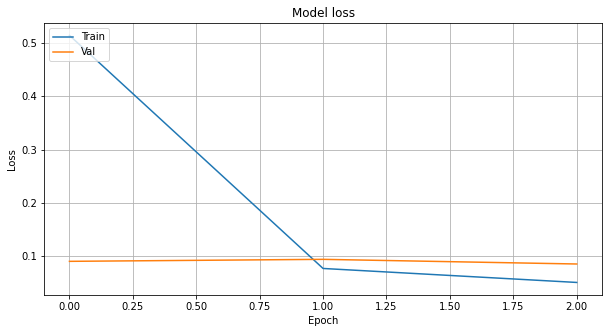

2020-08-17 18:41:09,358 : INFO : Saved file: ../predictions/cnn_early_stop_predictions.csv


CPU times: user 1min 18s, sys: 32.3 s, total: 1min 50s
Wall time: 30.4 s


In [20]:
%%time

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def early_stop(monitor='val_loss'):
    # val_loss
    # val_accuracy
    early_stopping = EarlyStopping(monitor=monitor, patience=10, mode='auto', verbose=1)
    model_checkpoint = ModelCheckpoint(args.model_name, save_best_only=True, monitor=monitor, mode='auto', verbose=1)
    reduce_lr_on_plateau = ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=3, verbose=1, min_delta=1e-4, mode='auto')

    model = build_baseline_model_sparse()
    history = model.fit(X, y_sparse, validation_split=args.val_fraction, epochs=args.epochs, batch_size=64, verbose=1, callbacks=[early_stopping, model_checkpoint, reduce_lr_on_plateau])

    plot_history(history)
    model.load_weights(args.model_name)
    predictions = model.predict(x)
    csv_predictions(predictions, 'cnn_early_stop_predictions.csv')
    
    if args.run_kfold_validation:
        cross_val_score_keras(build_baseline_model_sparse, X, y_sparse, fit_params={'validation_split': args.val_fraction, 'epochs': args.epochs, 'batch_size': 64, 'callbacks': [early_stopping, model_checkpoint, reduce_lr_on_plateau]})
    return predictions

if args.run_early_stop:
    basic_predictions = early_stop(monitor='val_accuracy')

### 2.3 Basic grid search to choose the best architecture

In [21]:
%%time 

# Todo check metrics for keras and grid search

from keras import layers 
from keras import models
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

def basic_grid_search():
    layers_candidates = {
        1: [layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')],

        2: [layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')],

        3: [layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')],

        4: [layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')],
    }
    
    def _build_model_grid_search(layers_candidates_key=1):
        return build_model(layers_candidates[layers_candidates_key])
    
    keras_classifier = KerasClassifier(_build_model_grid_search, 
                                       layers_candidates_key=1)
    # scoring='neg_log_loss', 'accuracy'
    # refit=False to avoid info leak to the future kfold validation
    gcv = GridSearchCV(keras_classifier,
                         param_grid={'epochs': [1, 2, 3, 4, 5, 10], 
                                     'layers_candidates_key': list(layers_candidates.keys())},
                         refit=False,
                         cv=args.n_splits,
                         scoring='neg_log_loss',
                         n_jobs=args.n_jobs,
                         verbose=2)
    gcv.fit(X, y_sparse)
    log.info('Best params: %s', repr(gcv.best_params_))
    log.info('Best CV score: %s', repr(gcv.best_score_))
    log.info('Best std: %s', repr(gcv.cv_results_['std_test_score'][gcv.best_index_]))
    return gcv, layers_candidates[gcv.best_params_['layers_candidates_key']]

def basic_grid_search_cv(best_grid_search_model, initial_weights):
    skf = StratifiedKFold(n_splits=args.n_splits, shuffle=True, random_state=args.seed)
    val_accuracies = np.array([])
    for train_index, val_index in skf.split(X, y_sparse):
        # Clearing the NN.
        best_grid_search_model.set_weights(initial_weights)
        history = best_grid_search_model.fit(X[train_index], y_sparse[train_index], validation_data=(X[val_index], y_sparse[val_index]), epochs=gcv.best_params_['epochs'], batch_size=64, verbose=1)
        scores = best_grid_search_model.evaluate(X[val_index], y_sparse[val_index], verbose=0)
        log.info('Iteration validation score: %s', repr(scores))
        val_accuracies = np.append(val_accuracies, scores[1])
    log.info('CV accuracy: %0.5f, std: ±%0.5f', np.mean(val_accuracies), np.std(val_accuracies))

if args.run_grid_search:
    gcv, layers_list = basic_grid_search()
    best_grid_search_model = build_model(layers_list)
    # saving initial weights to avoid info leak to cross val stage
    # keras doesn't reset weights, so cross validation starts with the weights that were used on the prev stage 
    # -> they are already adapted for the current validation fold
    initial_weights = best_grid_search_model.get_weights()
    if args.run_kfold_validation:
        basic_grid_search_cv(best_grid_search_model, initial_weights)
    best_grid_search_model.set_weights(initial_weights)
    history = best_grid_search_model.fit(X, y_sparse, epochs=gcv.best_params_['epochs'], batch_size=64, verbose=1)
    predictions = best_grid_search_model.predict(x)
    csv_predictions(predictions, 'cnn_basic_grid_search.csv')

CPU times: user 21 µs, sys: 1e+03 ns, total: 22 µs
Wall time: 25.7 µs


### 2.4 Error analysis

2020-08-18 17:16:23,636 : INFO : (28000, 10)
2020-08-18 17:16:23,638 : INFO : The most likely numbers for the less confident prediction: [2 8 9], probabilities: [0.19165124 0.34559584 0.23219493]
2020-08-18 17:16:23,639 : INFO : Most confused indices: [  683 20131 27724 23788 16323  2518 23874  4994  6734 24669]
2020-08-18 17:16:23,640 : INFO : The most likely numbers for the less confident predictions: 
[[2 8 9]
 [6 0 3]
 [9 3 8]
 [5 6 1]
 [6 5 0]
 [9 8 0]
 [7 3 5]
 [5 8 3]
 [7 8 3]
 [3 2 6]], 
probabilities: 
[[0.19 0.35 0.23]
 [0.19 0.22 0.37]
 [0.2  0.33 0.38]
 [0.25 0.35 0.39]
 [0.21 0.39 0.4 ]
 [0.26 0.36 0.37]
 [0.07 0.36 0.38]
 [0.25 0.32 0.41]
 [0.28 0.42 0.29]
 [0.21 0.33 0.42]]


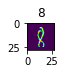

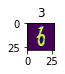

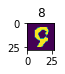

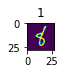

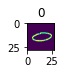

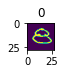

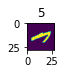

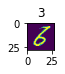

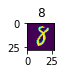

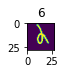

In [43]:
# analysis of the most confusing predicitons
def analyse_confusing_predictions(predictions=basic_predictions, n_confused=10, test_data=None):
    log.info(predictions.shape)
    probabilities_sparse = np.max(predictions, axis=1)
    min_prob = np.min(probabilities_sparse)
    min_index = np.argmin(probabilities_sparse, axis=0)
    log.info('The most likely numbers for the less confident prediction: %s, probabilities: %s', 
             np.argpartition(predictions[min_index], -3)[-3:], 
             predictions[min_index][np.argpartition(predictions[min_index], -3)[-3:]])
    
    most_confused_predictions_indices = np.argpartition(probabilities_sparse, n_confused)[:n_confused]
    log.info('Most confused indices: %s', most_confused_predictions_indices)
    most_confused_probabilities = predictions[most_confused_predictions_indices]
    likely_numbers_most_confused_probabilities = np.argpartition(most_confused_probabilities, -3, axis=1)[:, -3:]

    probabilities_likely_numbers_most_confused_probabilities = np.empty(likely_numbers_most_confused_probabilities.shape)
    for i, row in enumerate(most_confused_probabilities):
        probabilities_likely_numbers_most_confused_probabilities[i] = row[likely_numbers_most_confused_probabilities[i]]

    log.info('The most likely numbers for the less confident predictions: \n%s, \nprobabilities: \n%s', 
            likely_numbers_most_confused_probabilities,
            np.around(probabilities_likely_numbers_most_confused_probabilities, decimals=2))

    if test_data is not None:
        for most_confusing_predictions_index in most_confused_predictions_indices:
            plot_number(test_data.iloc[most_confusing_predictions_index, :].to_numpy().reshape(28, 28), label=np.argmax(basic_predictions[most_confusing_predictions_index]), size_inches=(0.5, 0.5))

analyse_confusing_predictions(predictions=basic_predictions, test_data=args.raw_test)

In [ ]:
# print confusing numbers

## 3. Model Evaluation

#### These numbers may vary from time to time 
| Approach | Model  | Test score  | CV mean score |
|---|---|---|---|
| Baseline | 50 epochs | 0.98657 | 0.98790 ±0.00069 |
| Early stop and reduction of learning rate (val_loss) | 9 epochs | 0.98932 | 0.98948 ±0.00059 |
| Early stop and reduction of learning rate (val_accuracy) | 14 epochs | 0.99003 | 0.99017 ±0.00037 |
| Basic grid search (accuracy) | 50 epochs out of 5, 15, 25, 50; layers: 1 | 0.98800 | 0.98631 ±0.00007 |
| Basic grid search (neg_log_loss) | 3 epochs out of 1, 2, 3, 5, 10; layers: 2 | 0.97989 | 0.98152 ±0.00263 |


#### These numbers may vary from time to time 
| Approach | Model  | Test score  |
|---|---|---|
| Baseline | No validation, 200 epochs  | 0.99157, 0.98857 |
| Baseline | Validation (20%), 45 epochs  | 0.98885 |
| Baseline | Validation (20%), 200 epochs, early stopping val_loss  | 0.98628 |
| Baseline | Validation (20%), 200 epochs, early stopping val_accuracy  | 0.98957 |
| Baseline | Validation (10%), 200 epochs, early stopping val_loss  | 0.98700 |
| Baseline | Validation (10%), 200 epochs, early stopping val_accuracy  | 0.98857 |
| K-Fold | Scoring neg_log_loss, cv=5  | 0.98200 |
| K-Fold | Scoring neg_log_loss, cv=12  | 0.98142 |